In [ ]:
! pip install xgboost

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")

In [ ]:
DATA_PATH = "dataset.csv"
df = pd.read_csv(DATA_PATH)

In [ ]:
df

,Unnamed: 0,open,high,low,close,volume,marketCap,timestamp,crypto_name,date
0,0,112.900002,118.800003,107.142998,115.910004,0.000000e+00,1.288693e+09,2013-05-05T23:59:59.999Z,Bitcoin,2013-05-05
1,1,3.493130,3.692460,3.346060,3.590890,0.000000e+00,6.229819e+07,2013-05-05T23:59:59.999Z,Litecoin,2013-05-05
2,2,115.980003,124.663002,106.639999,112.300003,0.000000e+00,1.249023e+09,2013-05-06T23:59:59.999Z,Bitcoin,2013-05-06
3,3,3.594220,3.781020,3.116020,3.371250,0.000000e+00,5.859436e+07,2013-05-06T23:59:59.999Z,Litecoin,2013-05-06
4,4,112.250000,113.444000,97.699997,111.500000,0.000000e+00,1.240594e+09,2013-05-07T23:59:59.999Z,Bitcoin,2013-05-07
...,...,...,...,...,...,...,...,...,...,...
72941,72941,0.022604,0.022988,0.022197,0.022796,4.040134e+07,1.652957e+09,2022-10-23T23:59:59.999Z,VeChain,2022-10-23
72942,72942,1.468244,1.530464,1.435415,1.517878,2.844351e+07,1.572825e+09,2022-10-23T23:59:59.999Z,Flow,2022-10-23
72943,72943,4.950431,5.148565,4.945280,5.117206,1.069497e+08,1.559551e+09,2022-10-23T23:59:59.999Z,Filecoin,2022-10-23
72944,72944,0.000233,0.000243,0.000226,0.000239,2.143268e+08,1.576291e+09,2022-10-23T23:59:59.999Z,Terra Classic,2022-10-23


In [ ]:
# Drop unnecessary index column
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)

# Convert dates
df["date"] = pd.to_datetime(df["date"])

# Sort properly (VERY IMPORTANT)
df = df.sort_values(["crypto_name", "date"]).reset_index(drop=True)

print("Data Loaded | Shape:", df.shape)

Data Loaded | Shape: (72946, 9)


In [ ]:

price_cols = ["open", "high", "low", "close"]

# Forward fill OHLC per crypto
df[price_cols] = df.groupby("crypto_name")[price_cols].ffill()

# Volume & marketCap handling
df["volume"] = df["volume"].fillna(0)
df["marketCap"] = df["marketCap"].fillna(df["marketCap"].median())

# Data consistency checks
df = df[df["low"] <= df["high"]]
df = df[(df["volume"] >= 0) & (df["marketCap"] > 0)]
df = df.drop_duplicates(subset=["crypto_name", "date"])

In [ ]:
# Log returns (group-wise)
df["log_return"] = np.log(
    df["close"] / df.groupby("crypto_name")["close"].shift(1)
)

# High-low spread
df["hl_spread"] = (df["high"] - df["low"]) / df["close"]

# Rolling volatility (TARGET VARIABLE)
df["volatility_14"] = (
    df.groupby("crypto_name")["log_return"]
      .rolling(14)
      .std()
      .reset_index(0, drop=True)
)
# Liquidity features
df["liquidity_ratio"] = df["volume"] / df["marketCap"]

df["volume_ma_7"] = (
    df.groupby("crypto_name")["volume"]
      .rolling(7)
      .mean()
      .reset_index(0, drop=True)
)

# Technical indicators
df["sma_14"] = (
    df.groupby("crypto_name")["close"]
      .rolling(14)
      .mean()
      .reset_index(0, drop=True)
)

df["ema_14"] = (
    df.groupby("crypto_name")["close"]
      .ewm(span=14, adjust=False)
      .mean()
      .reset_index(level=0, drop=True)
)
# Drop NaNs created by rolling features
df = df.dropna().reset_index(drop=True)

print("Feature Engineering Completed | Shape:", df.shape)

Feature Engineering Completed | Shape: (69701, 16)



Summary Statistics:
         log_return  volatility_14  liquidity_ratio
count  69701.000000   69701.000000     69701.000000
mean       0.001082       0.057919         0.252565
std        0.077953       0.051231         0.708719
min       -8.516598       0.000000         0.000000
25%       -0.025753       0.032714         0.027208
50%        0.000000       0.050730         0.076666
75%        0.026374       0.073765         0.209414
max        1.516382       2.328253        21.401189


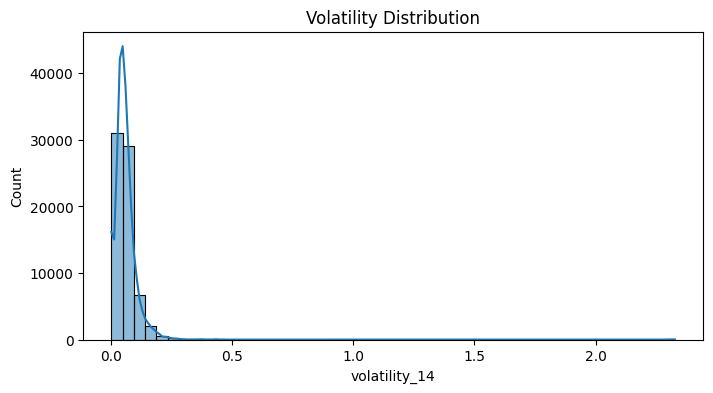

In [ ]:
print("\nSummary Statistics:")
print(df[["log_return","volatility_14","liquidity_ratio"]].describe())

plt.figure(figsize=(8,4))
sns.histplot(df["volatility_14"], bins=50, kde=True)
plt.title("Volatility Distribution")
plt.show()

In [ ]:
features = [
    "log_return",
    "hl_spread",
    "liquidity_ratio",
    "volume_ma_7",
    "sma_14",
    "ema_14"
]

X = df[features]
y = df["volatility_14"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
split_index = int(len(X_scaled) * 0.8)

X_train = X_scaled[:split_index]
X_test  = X_scaled[split_index:]

y_train = y.iloc[:split_index]
y_test  = y.iloc[split_index:]

In [ ]:
model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
pred = model.predict(X_test)

mse = mean_squared_error(y_test, pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, pred)
r2 = r2_score(y_test, pred)

print("\nModel Performance:")
print(f"RMSE : {rmse:.6f}")
print(f"MAE  : {mae:.6f}")
print(f"R²   : {r2:.4f}")


Model Performance:
RMSE : 0.028094
MAE  : 0.019508
R²   : 0.5247


In [ ]:
param_grid = {
    "max_depth": [3,5,7],
    "learning_rate": [0.01,0.05,0.1],
    "n_estimators": [100,200,300]
}

search = RandomizedSearchCV(
    model,
    param_grid,
    n_iter=8,
    cv=3,
    scoring="neg_root_mean_squared_error",
    random_state=42
)

search.fit(X_train, y_train)
print("\nBest Params:", search.best_params_)


Best Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05}


In [ ]:
imp = pd.DataFrame({
    "Feature": features,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

print("\nFeature Importance:")
print(imp)


Feature Importance:
           Feature  Importance
1        hl_spread    0.294913
4           sma_14    0.185212
5           ema_14    0.154607
0       log_return    0.142424
3      volume_ma_7    0.125519
2  liquidity_ratio    0.097325


In [ ]:
# Save model
joblib.dump(model, "xgb_volatility_model.pkl")
joblib.dump(scaler, "scaler.pkl")

print("\nModel & scaler saved")


Model & scaler saved


In [ ]:
!pip install Flask
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 88.6 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok

In [ ]:
from flask import Flask, request, jsonify
import streamlit as st
from threading import Thread
from pyngrok import ngrok

In [ ]:
FEATURES = [
    "log_return",
    "hl_spread",
    "liquidity_ratio",
    "volume_ma_7",
    "sma_14",
    "ema_14"
]

In [ ]:
app = Flask(__name__)

@app.route("/", methods=["GET"])
def home():
    return jsonify({"status": "Crypto Volatility API running"})

# @app.route("/predict", methods=["POST"])
# def predict():
#     try:
#         data = request.get_json(force=True)
#         df_input = pd.DataFrame(data)

#         missing = [c for c in FEATURES if c not in df_input.columns]
#         if missing:
#             return jsonify({"error": f"Missing columns: {missing}"}), 400

#         X_input = scaler.transform(df_input[FEATURES])
#         preds = model.predict(X_input)

#         return jsonify({"predicted_volatility": preds.tolist()})

    # except Exception as e:
    #     return jsonify({"error": str(e)}), 500
@app.route("/predict", methods=["GET", "POST"])
def predict():
    if request.method == "GET":
        return jsonify({
            "message": "Use POST with JSON body to get predictions"
        })

    data = request.get_json(force=True)
    df_input = pd.DataFrame(data)
    X_input = scaler.transform(df_input[FEATURES])
    preds = model.predict(X_input)
    return jsonify({"predicted_volatility": preds.tolist()})


def run_app():
    app.run(port=5000, debug=False, use_reloader=False)

# Start Flask in background
thread = Thread(target=run_app)
thread.start()

# Set ngrok authtoken (replace 'YOUR_AUTHTOKEN' with your actual token)
# You can get one from https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token("39CGGRaAEXwesimKRFhQbt8BnEr_5i2WV85NSrwVdSaZ4SmZz")

# Start ngrok tunnel
public_url = ngrok.connect(5000)
print("Public API URL:", public_url)

 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


Public API URL: NgrokTunnel: "https://broderick-councilmanic-nonadjunctively.ngrok-free.dev" -> "http://localhost:5000"


In [ ]:
import requests

url = "https://broderick-councilmanic-nonadjunctively.ngrok-free.dev/predict"

data = [{
    "log_return": 0.01,
    "hl_spread": 0.03,
    "liquidity_ratio": 0.002,
    "volume_ma_7": 1e8,
    "sma_14": 30000,
    "ema_14": 29800
}]

r = requests.post(url, json=data)
print(r.status_code)
print(r.json())

INFO:werkzeug:127.0.0.1 - - [04/Feb/2026 12:13:20] "POST /predict HTTP/1.1" 200 -


200
{'predicted_volatility': [0.03794439882040024]}


In [ ]:
import requests

url = public_url.public_url + "/predict"

data = [{
    "log_return": 0.01,
    "hl_spread": 0.03,
    "liquidity_ratio": 0.002,
    "volume_ma_7": 1e8,
    "sma_14": 30000,
    "ema_14": 29800
}]

response = requests.post(url, json=data)
print(response.status_code)
print(response.json())

INFO:werkzeug:127.0.0.1 - - [04/Feb/2026 12:13:23] "POST /predict HTTP/1.1" 200 -


200
{'predicted_volatility': [0.03794439882040024]}


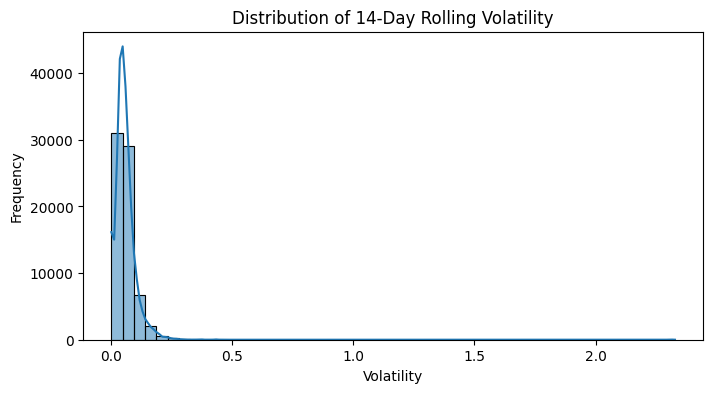

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(df["volatility_14"], bins=50, kde=True)
plt.title("Distribution of 14-Day Rolling Volatility")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.show()

What this graph shows

A histogram (with KDE curve) of 14-day rolling volatility values across all cryptocurrencies and dates.

Key observations

The distribution is right-skewed.

Most volatility values are close to zero, indicating relatively calm market conditions most of the time.

A long right tail shows rare but extreme volatility spikes.

Interpretation

Cryptocurrency markets experience volatility clustering: long stable periods followed by sudden spikes.

Extreme events (news, crashes, rallies) cause very high volatility but occur infrequently.

Why this matters

Confirms that volatility is non-normal, justifying:

Rolling features

Non-linear models like XGBoost

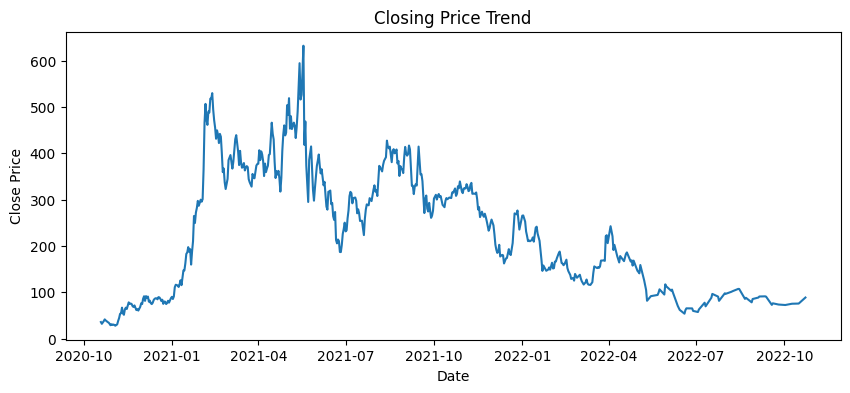

In [ ]:
btc = df[df["crypto_name"] == df["crypto_name"].iloc[0]]

plt.figure(figsize=(10,4))
plt.plot(btc["date"], btc["close"])
plt.title("Closing Price Trend")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.show()

What this graph shows

Time-series line plot of the closing price of a cryptocurrency over time.

Key observations

Clear uptrends and downtrends are visible.

Sharp rises followed by steep drops indicate high price instability.

Prices do not move smoothly; instead, they show sudden jumps and corrections.

Interpretation

Cryptocurrency prices are highly speculative and sensitive to market sentiment.

Strong trends explain why moving averages (SMA, EMA) are useful features.

Why this matters

Justifies the use of:

Trend-based indicators

Time-series modeling

Shows that raw prices alone are noisy → feature engineering is required.

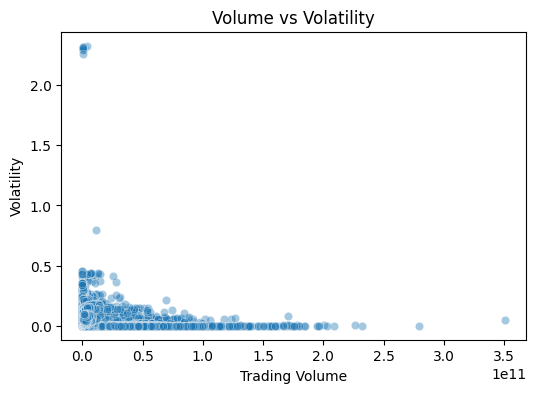

In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=df["volume"],
    y=df["volatility_14"],
    alpha=0.4
)
plt.title("Volume vs Volatility")
plt.xlabel("Trading Volume")
plt.ylabel("Volatility")
plt.show()

What this graph shows

Scatter plot between trading volume (x-axis) and volatility (y-axis).

Key observations

At low volumes, volatility varies widely.

As volume increases, volatility generally reduces or stabilizes.

A few outliers show very high volatility at low volume.

Interpretation

Low-liquidity assets are more volatile.

High trading volume usually implies better liquidity, which absorbs price shocks.

Why this matters

Strongly supports using liquidity features like:

Volume

Volume moving averages

Volume / MarketCap ratio

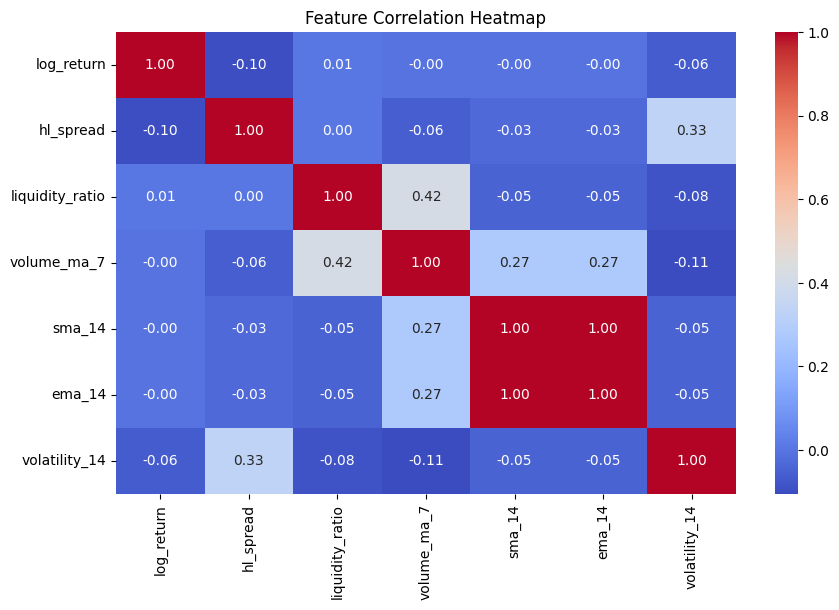

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(
    df[[
        "log_return",
        "hl_spread",
        "liquidity_ratio",
        "volume_ma_7",
        "sma_14",
        "ema_14",
        "volatility_14"
    ]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)
plt.title("Feature Correlation Heatmap")
plt.show()

What this graph shows

Pairwise correlation coefficients between engineered features and volatility.

Key observations

hl_spread has a moderate positive correlation with volatility (~0.33).

Liquidity features (liquidity_ratio, volume_ma_7) show meaningful relationships.

sma_14 and ema_14 are highly correlated with each other (expected).

No extremely high correlation between most features → low multicollinearity.

Interpretation

High-Low spread is a strong volatility indicator.

Liquidity impacts volatility more than raw returns.

Moving averages capture trend but not volatility directly.

Why this matters

Confirms feature selection is statistically justified.

Validates model stability (no severe multicollinearity issues).

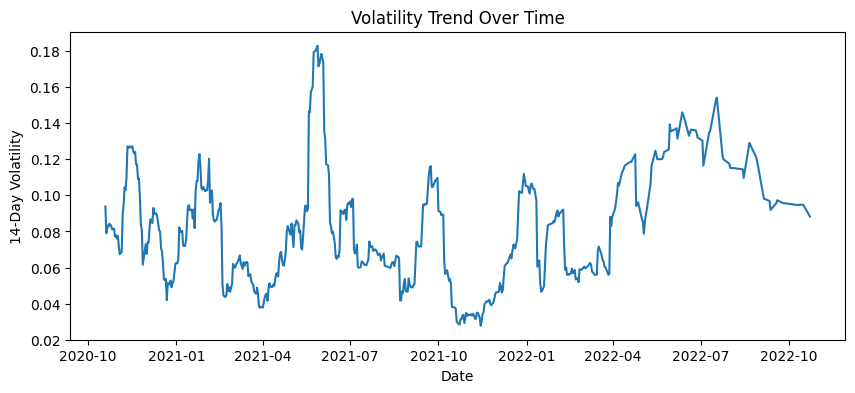

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(btc["date"], btc["volatility_14"])
plt.title("Volatility Trend Over Time")
plt.xlabel("Date")
plt.ylabel("14-Day Volatility")
plt.show()

What this graph shows

Time-series plot of 14-day rolling volatility.

Key observations

Volatility appears in clusters, not randomly.

Periods of sustained high volatility are followed by calmer phases.

Spikes correspond to market stress or major price movements.

Interpretation

Volatility is persistent (autocorrelated).

Past volatility contains information about future volatility.

Why this matters

Justifies predicting volatility using lagged and rolling features.

Supports the choice of regression-based time-aware modeling.